In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Seed for reproducibility
np.random.seed(42)

# Simulate data
n_samples = 200
Size = np.random.normal(2000, 400, n_samples)     # in sqft
Bedrooms = np.random.randint(2, 6, n_samples)     # 2 to 5 bedrooms
Bathrooms = np.random.randint(1, 4, n_samples)    # 1 to 3 bathrooms
Garage = np.random.randint(0, 3, n_samples)       # 0 to 2 car garage
Age = np.random.randint(0, 50, n_samples)         # house age in years

# True coefficients for house price (per realistic assumptions)
beta0 = 50000       # base price
beta_size = 150     # $ per sqft
beta_bedrooms = 10000
beta_bathrooms = 12000
beta_garage = 8000
beta_age = -1000    # depreciation per year

# Simulate house price with noise
noise = np.random.normal(0, 20000, n_samples)
Price = (beta0 + beta_size*Size + beta_bedrooms*Bedrooms + beta_bathrooms*Bathrooms +
         beta_garage*Garage + beta_age*Age + noise)

# Create DataFrame
df = pd.DataFrame({
    'Price': Price,
    'Size': Size,
    'Bedrooms': Bedrooms,
    'Bathrooms': Bathrooms,
    'Garage': Garage,
    'Age': Age
})


In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [16]:
X = df[['Size', 'Bedrooms', 'Bathrooms', 'Garage', 'Age']]
y = df['Price']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Initialize and fit Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [19]:
# Coefficients
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_model.coef_
})

print(coefficients)
print(f"Intercept: {lr_model.intercept_:.2f}")

     Feature   Coefficient
0       Size    141.179964
1   Bedrooms   7879.827643
2  Bathrooms  12278.865691
3     Garage  10824.925412
4        Age   -962.382668
Intercept: 70599.68


In [20]:
# Predict on test data
y_pred = lr_model.predict(X_test)

# Metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Test R-squared: {r2:.4f}")
print(f"Test RMSE: ${rmse:,.2f}")

Test R-squared: 0.8842
Test RMSE: $18,044.99


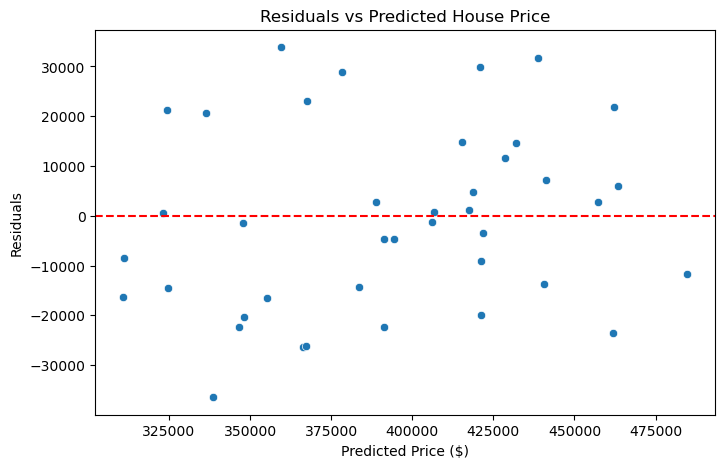

In [21]:
residuals = y_test - y_pred

plt.figure(figsize=(8,5))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted House Price")
plt.xlabel("Predicted Price ($)")
plt.ylabel("Residuals")
plt.show()

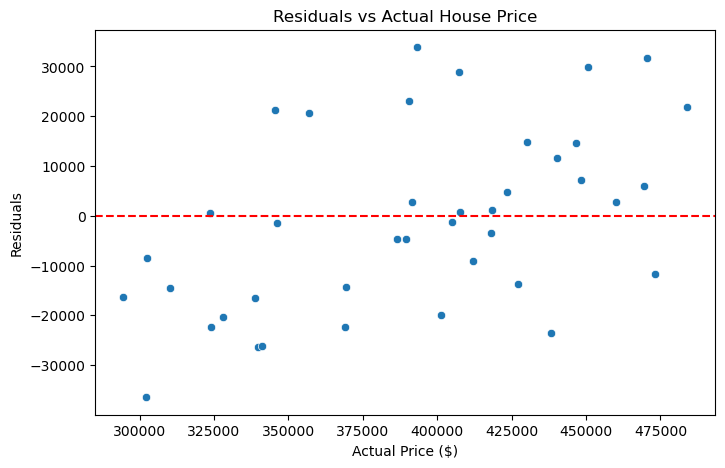

In [22]:
residuals = y_test - y_pred

plt.figure(figsize=(8,5))
sns.scatterplot(x=y_test, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Actual House Price")
plt.xlabel("Actual Price ($)")
plt.ylabel("Residuals")
plt.show()

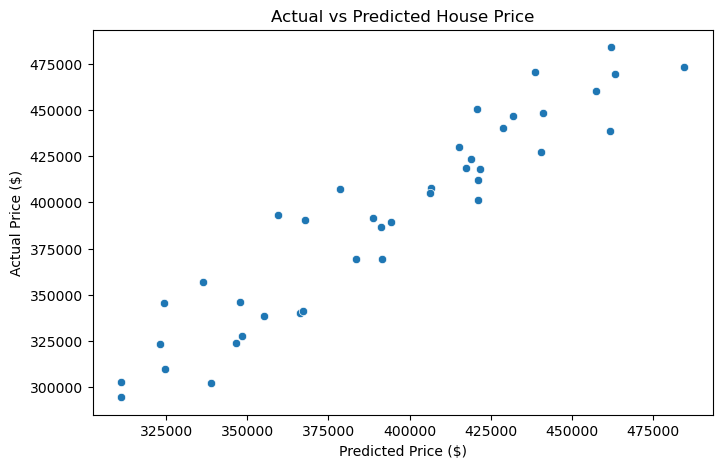

In [13]:
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_pred, y=y_test)
plt.title("Actual vs Predicted House Price")
plt.xlabel("Predicted Price ($)")
plt.ylabel("Actual Price ($)")
plt.show()

In [23]:
from sklearn.utils import resample

# Assume X_train, y_train are already defined from previous steps

# Bootstrapping for confidence intervals
n_bootstraps = 1000
coefs = []

for _ in range(n_bootstraps):
    X_sample, y_sample = resample(X_train, y_train)
    model = LinearRegression().fit(X_sample, y_sample)
    coefs.append(model.coef_)

coefs = np.array(coefs)

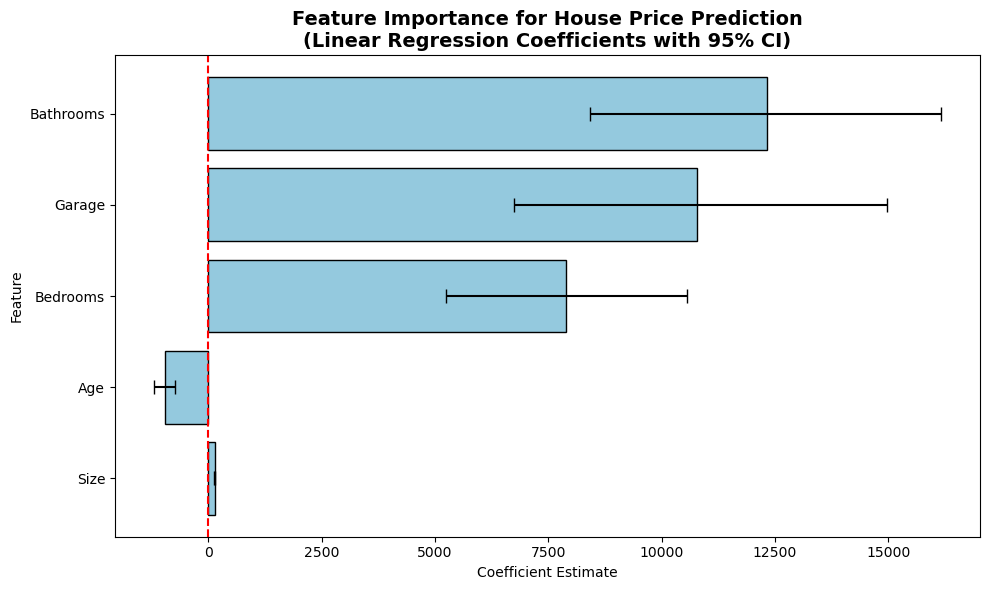

In [24]:
coef_mean = np.mean(coefs, axis=0)
coef_lower = np.percentile(coefs, 2.5, axis=0)
coef_upper = np.percentile(coefs, 97.5, axis=0)

# Prepare DataFrame
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coef_mean,
    'CI Lower': coef_lower,
    'CI Upper': coef_upper
}).sort_values(by='Coefficient', key=abs, ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coef_df, color='skyblue', edgecolor='black')

# Error bars (CI)
plt.errorbar(coef_df['Coefficient'], coef_df['Feature'],
             xerr=[coef_df['Coefficient'] - coef_df['CI Lower'], coef_df['CI Upper'] - coef_df['Coefficient']],
             fmt='none', ecolor='black', capsize=5)

plt.title("Feature Importance for House Price Prediction\n(Linear Regression Coefficients with 95% CI)", fontsize=14, fontweight="bold")
plt.xlabel("Coefficient Estimate")
plt.ylabel("Feature")
plt.axvline(0, color='red', linestyle='--')
plt.tight_layout()
plt.show()

In [25]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

In [26]:
# Define Ridge regression with CV for best alpha (regularization strength)
ridge = Ridge()

# Search over a range of alpha values
param_grid = {'alpha': np.logspace(-3, 3, 20)}

ridge_cv = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')
ridge_cv.fit(X_train, y_train)

# Best alpha value
best_alpha = ridge_cv.best_params_['alpha']
print(f"Best alpha from CV: {best_alpha}")


Best alpha from CV: 2.976351441631316


In [27]:
# Fit final Ridge model with best alpha
ridge_model = Ridge(alpha=best_alpha)
ridge_model.fit(X_train, y_train)

# Coefficients
ridge_coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': ridge_model.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

print(ridge_coef_df)

     Feature   Coefficient
2  Bathrooms  11959.159276
3     Garage  10516.148445
1   Bedrooms   7744.285307
4        Age   -963.142679
0       Size    141.240333


In [28]:
# Predictions on test data
y_pred_ridge = ridge_model.predict(X_test)

# R2 and RMSE
ridge_r2 = r2_score(y_test, y_pred_ridge)
ridge_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ridge))

print(f"Ridge R-squared: {ridge_r2:.4f}")
print(f"Ridge RMSE: ${ridge_rmse:,.2f}")


Ridge R-squared: 0.8848
Ridge RMSE: $18,000.79


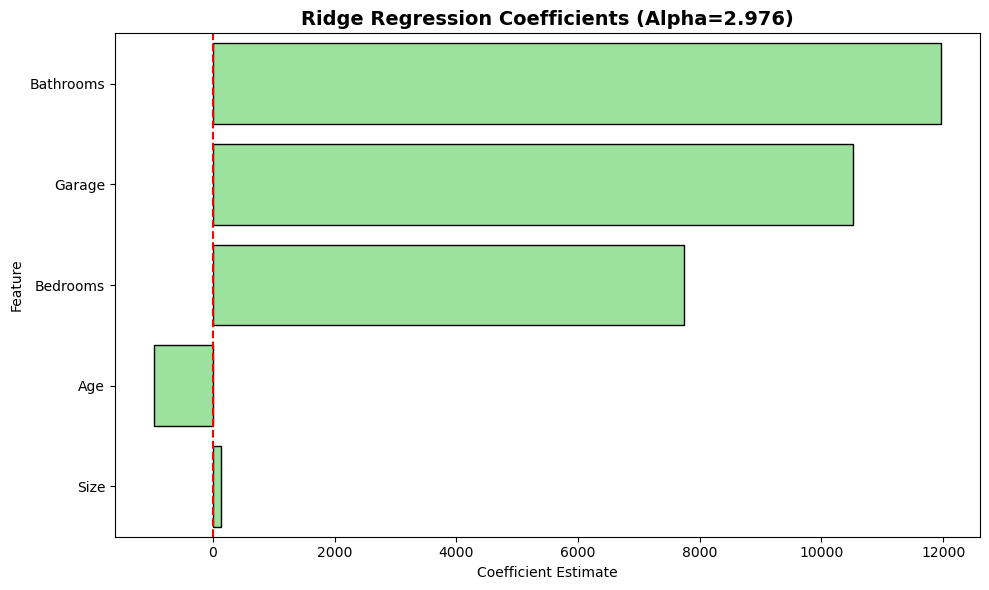

In [29]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=ridge_coef_df, color='lightgreen', edgecolor='black')
plt.title(f"Ridge Regression Coefficients (Alpha={best_alpha:.3f})", fontsize=14, fontweight="bold")
plt.xlabel("Coefficient Estimate")
plt.axvline(0, color='red', linestyle='--')
plt.tight_layout()
plt.show()

In [30]:
# OLS coefficients (from scikit-learn LinearRegression)
ols_model = LinearRegression()
ols_model.fit(X_train, y_train)

# Create DataFrame for OLS and Ridge Coefficients
comparison_df = pd.DataFrame({
    'Feature': X.columns,
    'OLS Coef': ols_model.coef_,
    'Ridge Coef': ridge_model.coef_
}).melt(id_vars='Feature', var_name='Model', value_name='Coefficient')


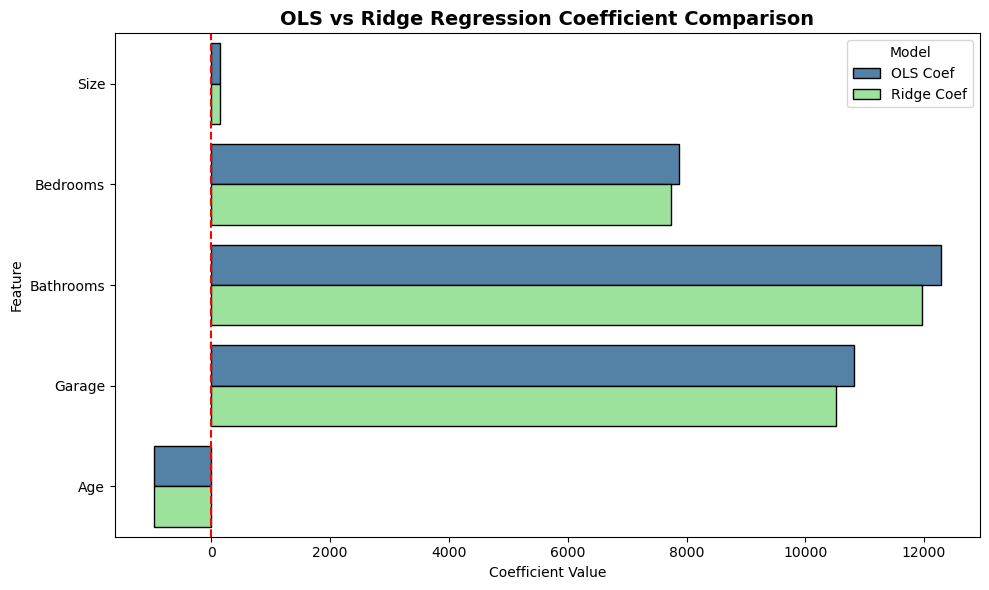

In [31]:
plt.figure(figsize=(10, 6))
sns.barplot(data=comparison_df, x='Coefficient', y='Feature', hue='Model', palette=['steelblue', 'lightgreen'], edgecolor='black')

plt.title("OLS vs Ridge Regression Coefficient Comparison", fontsize=14, fontweight="bold")
plt.axvline(0, color='red', linestyle='--')
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.legend(title="Model", loc="best")
plt.tight_layout()
plt.show()